In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
uniref90_aligned_binary_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniref90_aligned_multi_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniprot_aligned_binary_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniprot_aligned_multi_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")

uniref90_aligned_csv_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/uniref/aligned/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
uniprot_aligned_csv_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"

In [4]:
s_mutations_df = pd.read_csv(s_mutations_file_path)
print(s_mutations_df.shape)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] +  "_" + s_mutations_df["pos"].astype("str") + "_" + s_mutations_df["new_token"]
s_mutations_df.head(15)

(13, 3)


,orig_token,pos,new_token,perturbation_id
0,D,614,G,D_614_G
1,S,943,P,S_943_P
2,E,484,K,E_484_K
3,N,501,Y,N_501_Y
4,L,452,R,L_452_R
5,Q,677,P,Q_677_P
6,Q,677,H,Q_677_H
7,P,681,H,P_681_H
8,E,484,Q,E_484_Q
9,K,417,N,K_417_N


In [5]:
uniref90_df = pd.read_csv(uniref90_aligned_csv_file_path)
print(uniref90_df.shape)
uniprot_df = pd.read_csv(uniprot_aligned_csv_file_path)
print(uniprot_df.shape)

(682, 6)
(3568, 6)


### WIV04 reference sequence

In [6]:
def get_wiv04_position_mapping(df, id):
    wiv04_df = df[df[id] == "WIV04"]
    wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
    
    print(wiv04_aligned_seq)
    
    wiv04_position_mapping = {}
    pos = 0
    for i, token in enumerate(wiv04_aligned_seq):
        if token == "-":
            continue
        else:
            pos += 1
            wiv04_position_mapping[i] = pos
    return wiv04_position_mapping

In [7]:
uniref90_wiv04_position_mapping = get_wiv04_position_mapping(uniref90_df, "uniref90_id")

--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP--------

In [8]:
uniprot_wiv04_position_mapping = get_wiv04_position_mapping(uniprot_df, "uniprot_id")

-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST------

In [9]:
columns = ["id", human_label, "y_true", "orig_token", "perturb_seq_pos", "new_token", pred_diff_col, f"abs_{pred_diff_col}", "perturb_pos", "perturbation_id"]

def get_perturbation_results_df(dir_path, wiv04_position_mapping):
    perturbed_output_dfs = []
    perturbation_output_files = os.listdir(dir_path)
    print(f"Number of files: {len(perturbation_output_files)}")
    # read all the files for each experiment
    count = 0
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(dir_path, perturbation_output_file))
        # compute the perturbation difference
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        
        
        # compute the perturb_seq_pos
        try:
            df["perturb_seq_pos"] = df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
            df["perturb_seq_pos"] = df["perturb_seq_pos"].astype("Int64")
        except: 
            pass
        
        perturbed_output_dfs.append(get_mutations_df(df))
            
    perturbed_output_df = pd.concat(perturbed_output_dfs)
    perturbed_output_df.rename(columns={"uniref90_id": "id", "uniprot_id": "id"}, inplace=True)
    
    perturbed_output_df["perturbation_id"] = perturbed_output_df["orig_token"] +  "_" + perturbed_output_df["perturb_seq_pos"].astype("str") + "_" + perturbed_output_df["new_token"]
    print(f"Number of sequences with mutations = {count}")
    return perturbed_output_df[columns]


In [10]:
def check_df_contain_mutation(df):
    for _, row in s_mutations_df.iterrows():
        # mutation_df = df[df["perturbation_id"] == row["perturbation_id"]]
        mutation_df = df[(df["orig_token"] == row["orig_token"]) & (df["perturb_seq_pos"] == row["pos"])]
        if mutation_df.shape[0] > 0:
            print(f"Contains {row['perturbation_id']}")
            return True
    print(f"Does not contain any of the mutations")
    return False


def get_mutations_df(df):
    mutations_dfs = []
    for _, row in s_mutations_df.iterrows():
        # mutation_df = df[df["perturbation_id"] == row["perturbation_id"]]
        mutation_df = df[(df["orig_token"] == row["orig_token"]) & (df["perturb_seq_pos"] == row["pos"])]
        mutations_dfs.append(mutation_df)
    return pd.concat(mutations_dfs)

In [22]:
dir_paths = {
    "UniRef90-Aligned-Binary": uniref90_aligned_binary_dir_path,
    # "UniRef90-Aligned-Multi": uniref90_aligned_multi_dir_path,
    # "UniProt-Aligned-Binary": uniprot_aligned_binary_dir_path,
    #"UniProt-Aligned-Multi": uniprot_aligned_multi_dir_path
}

experiment_stats = []
mutations_dfs = []
for key, dir_path in dir_paths.items():
    wiv04_position_mapping = None
    print(f"Experiment: {key}")
    if "UniRef90" in key:
        print("UniRef90 WIV04 Mapping")
        wiv04_position_mapping = uniref90_wiv04_position_mapping
    else:
        print("UniProt WIV04 Mapping")
        wiv04_position_mapping = uniprot_wiv04_position_mapping
    
    perturbed_output_df = get_perturbation_results_df(dir_path, wiv04_position_mapping)
    perturbed_output_df["experiment"] = key
    
#     mutations_df = get_mutations_df(perturbed_output_df)
#     print(f"mutations_df = {mutations_df.shape}")
    
#     mutations_dfs.append(mutations_df)
    
#    mutations_dfs.append(perturbed_output_df)
# mutations_df_all = pd.concat(mutations_dfs)
# print(mutations_df_all.shape)
print(perturbed_output_df.shape)

Experiment: UniRef90-Aligned-Binary
UniRef90 WIV04 Mapping
Number of files: 94
Number of sequences with mutations = 0
(24725, 11)


In [23]:
perturbed_output_df.head()

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,perturbation_id,experiment
783,UniRef90_A0A8B6RAI1,0.988147,Human,S,943,X,0.0,0.0,2004,S_943_X,UniRef90-Aligned-Binary
2168,UniRef90_A0A8B6RAI1,0.988147,Human,S,943,G,0.0,0.0,2004,S_943_G,UniRef90-Aligned-Binary
4329,UniRef90_A0A8B6RAI1,0.988147,Human,S,943,W,0.0,0.0,2004,S_943_W,UniRef90-Aligned-Binary
6442,UniRef90_A0A8B6RAI1,0.988147,Human,S,943,L,0.0,0.0,2004,S_943_L,UniRef90-Aligned-Binary
9032,UniRef90_A0A8B6RAI1,0.988147,Human,S,943,A,0.0,0.0,2004,S_943_A,UniRef90-Aligned-Binary


In [24]:
mutations_df_all = perturbed_output_df

i = 0, mutation_idx=0, perturbation_id=D_614_G
i = 1, mutation_idx=1, perturbation_id=S_943_P
i = 2, mutation_idx=2, perturbation_id=E_484_K
i = 3, mutation_idx=3, perturbation_id=N_501_Y
i = 4, mutation_idx=4, perturbation_id=L_452_R
i = 5, mutation_idx=5, perturbation_id=Q_677_P
i = 6, mutation_idx=6, perturbation_id=Q_677_H
i = 7, mutation_idx=7, perturbation_id=P_681_H
i = 8, mutation_idx=8, perturbation_id=E_484_Q
i = 9, mutation_idx=9, perturbation_id=K_417_N
i = 10, mutation_idx=10, perturbation_id=K_417_T
i = 11, mutation_idx=11, perturbation_id=S_477_G


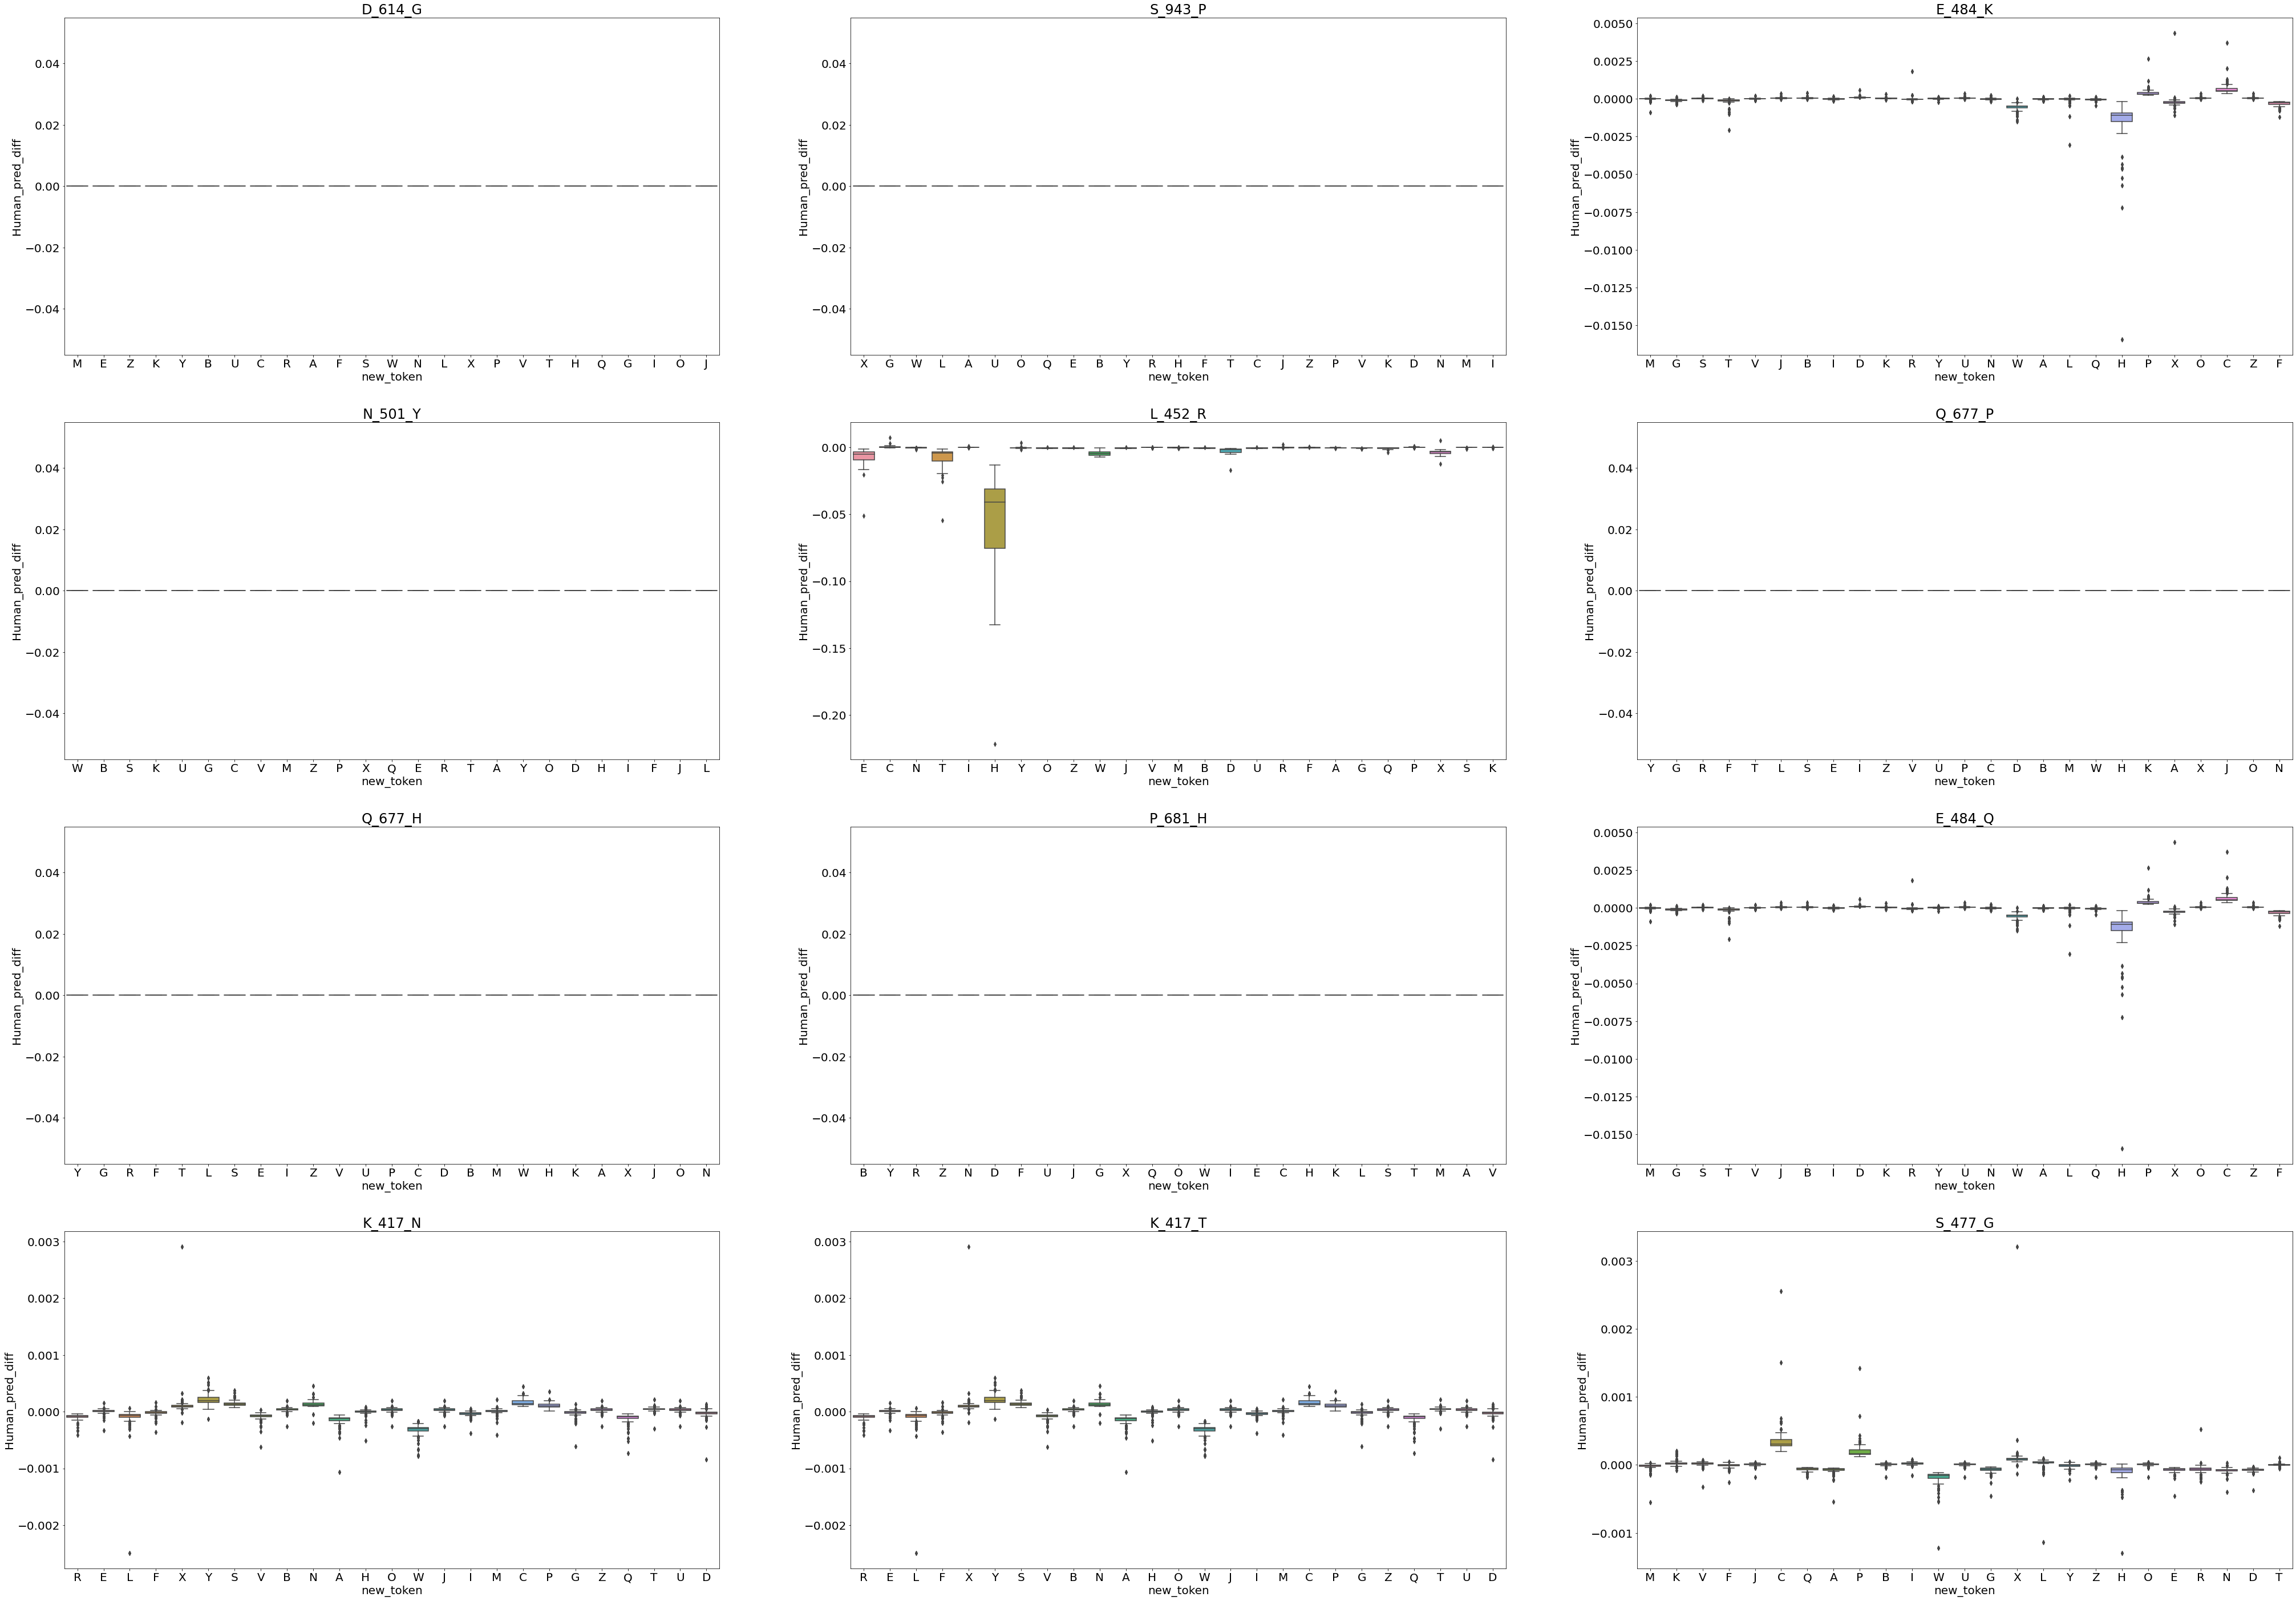

In [25]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})
fig, axs =plt.subplots(4, 3, figsize=(70, 50))#, gridspec_kw={'height_ratios': [.5, 1, 1, 1, 1]})
for i, ax in enumerate(axs.flatten()):
    orig_token = s_mutations_df.loc[i, "orig_token"]
    pos = s_mutations_df.loc[i, "pos"]
    new_token = s_mutations_df.loc[i,"new_token"]
    perturbation_id = s_mutations_df.loc[i, "perturbation_id"]
    print(f"i = {i}, mutation_idx={i}, perturbation_id={perturbation_id}")

    plot_df = mutations_df_all[(mutations_df_all["orig_token"] == orig_token) & (mutations_df_all["perturb_seq_pos"] == pos)]
    n_seq = plot_df["id"].nunique()
    #plot_df["new_token_val"] = plot_df["new_token"].apply(lambda x: x if x == new_token else "Others")
    plot_df = plot_df.reset_index()
    sns.boxplot(data=plot_df, x="new_token", y=pred_diff_col, ax=ax)
    ax.set_title(perturbation_id)
plt.show()

i = 0, mutation_idx=0, perturbation_id=D_614_G
i = 1, mutation_idx=1, perturbation_id=S_943_P
i = 2, mutation_idx=2, perturbation_id=E_484_K
i = 3, mutation_idx=3, perturbation_id=N_501_Y
i = 4, mutation_idx=4, perturbation_id=L_452_R
i = 5, mutation_idx=5, perturbation_id=Q_677_P
i = 6, mutation_idx=6, perturbation_id=Q_677_H
i = 7, mutation_idx=7, perturbation_id=P_681_H
i = 8, mutation_idx=8, perturbation_id=E_484_Q
i = 9, mutation_idx=9, perturbation_id=K_417_N
i = 10, mutation_idx=10, perturbation_id=K_417_T
i = 11, mutation_idx=11, perturbation_id=S_477_G


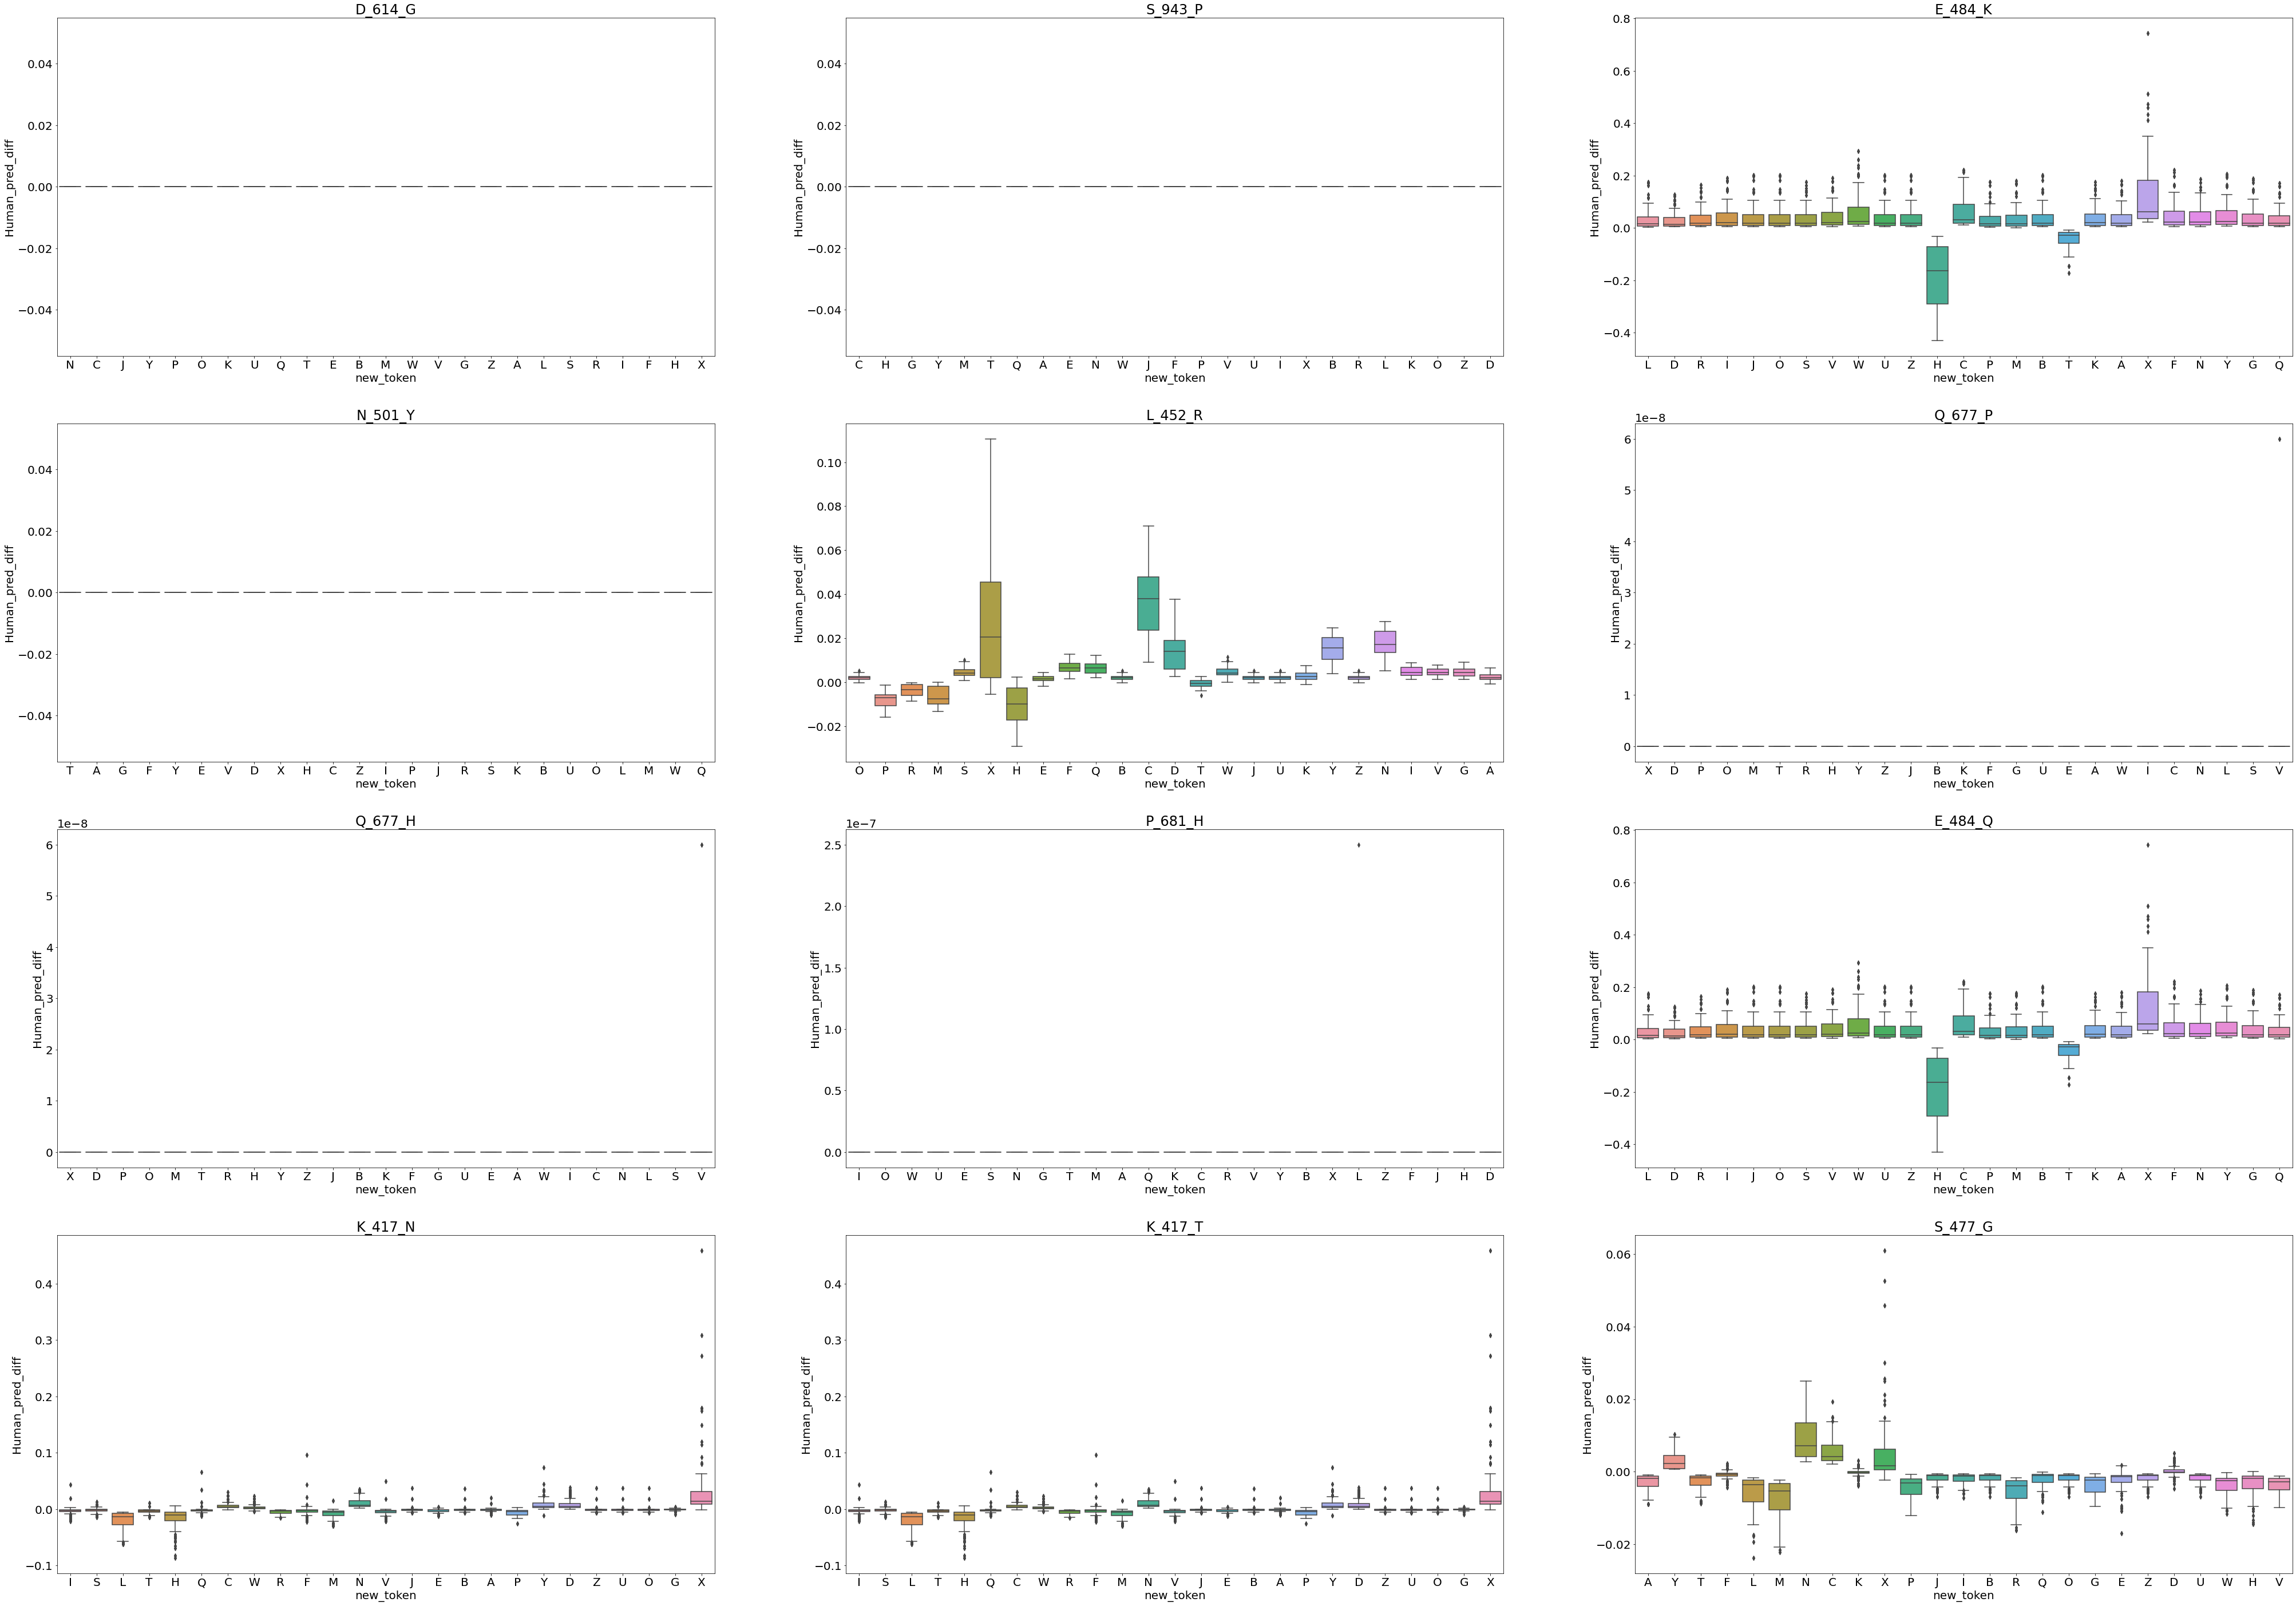

In [69]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})
fig, axs =plt.subplots(4, 3, figsize=(70, 50))#, gridspec_kw={'height_ratios': [.5, 1, 1, 1, 1]})
for i, ax in enumerate(axs.flatten()):
    orig_token = s_mutations_df.loc[i, "orig_token"]
    pos = s_mutations_df.loc[i, "pos"]
    new_token = s_mutations_df.loc[i,"new_token"]
    perturbation_id = s_mutations_df.loc[i, "perturbation_id"]
    print(f"i = {i}, mutation_idx={i}, perturbation_id={perturbation_id}")

    plot_df = mutations_df_all[(mutations_df_all["orig_token"] == orig_token) & (mutations_df_all["perturb_seq_pos"] == pos)]
    n_seq = plot_df["id"].nunique()
    #plot_df["new_token_val"] = plot_df["new_token"].apply(lambda x: x if x == new_token else "Others")
    plot_df = plot_df.reset_index()
    sns.boxplot(data=plot_df, x="new_token", y=pred_diff_col, ax=ax)
    ax.set_title(perturbation_id)
plt.show()

In [65]:
plot_df

,index,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,perturbation_id,experiment
0,358,WIV04,0.208681,Human,D,614,N,0.0,0.0,1595,D_614_N,UniRef90-Aligned-Multi
1,504,WIV04,0.208681,Human,D,614,C,0.0,0.0,1595,D_614_C,UniRef90-Aligned-Multi
2,822,WIV04,0.208681,Human,D,614,J,0.0,0.0,1595,D_614_J,UniRef90-Aligned-Multi
3,984,WIV04,0.208681,Human,D,614,Y,0.0,0.0,1595,D_614_Y,UniRef90-Aligned-Multi
4,3533,WIV04,0.208681,Human,D,614,P,0.0,0.0,1595,D_614_P,UniRef90-Aligned-Multi
5,4270,WIV04,0.208681,Human,D,614,O,0.0,0.0,1595,D_614_O,UniRef90-Aligned-Multi
6,7674,WIV04,0.208681,Human,D,614,K,0.0,0.0,1595,D_614_K,UniRef90-Aligned-Multi
7,9555,WIV04,0.208681,Human,D,614,U,0.0,0.0,1595,D_614_U,UniRef90-Aligned-Multi
8,11201,WIV04,0.208681,Human,D,614,Q,0.0,0.0,1595,D_614_Q,UniRef90-Aligned-Multi
9,14522,WIV04,0.208681,Human,D,614,T,0.0,0.0,1595,D_614_T,UniRef90-Aligned-Multi


In [49]:
sum(plot_df.index.duplicated())

84

In [39]:
plot_df[plot_df.index.duplicated()].sort_values(by=plot_df.index, axis=0, ignore_index=True)

KeyError: Int64Index([  614,   942,  1511,  2415,  2860,  5041,  5571,  6100,  8767,
             8927,
            ...
            19035, 19062, 21662, 21946, 22376, 22434, 24922, 24967, 25072,
            27533],
           dtype='int64', length=2325)

In [45]:
sorted(list(plot_df.index))

[2,
 17,
 22,
 28,
 28,
 42,
 47,
 54,
 79,
 83,
 100,
 108,
 151,
 155,
 163,
 167,
 168,
 205,
 221,
 249,
 262,
 274,
 285,
 328,
 383,
 389,
 419,
 424,
 424,
 426,
 434,
 440,
 450,
 452,
 453,
 467,
 473,
 494,
 518,
 519,
 525,
 537,
 561,
 595,
 614,
 626,
 650,
 665,
 674,
 676,
 702,
 704,
 710,
 710,
 718,
 744,
 754,
 756,
 759,
 812,
 821,
 825,
 833,
 846,
 855,
 894,
 899,
 913,
 923,
 926,
 942,
 958,
 966,
 1048,
 1067,
 1069,
 1070,
 1089,
 1098,
 1118,
 1147,
 1153,
 1161,
 1207,
 1211,
 1221,
 1238,
 1250,
 1261,
 1270,
 1290,
 1299,
 1299,
 1303,
 1349,
 1350,
 1374,
 1405,
 1406,
 1417,
 1433,
 1438,
 1447,
 1496,
 1503,
 1511,
 1511,
 1519,
 1525,
 1549,
 1550,
 1565,
 1573,
 1574,
 1610,
 1638,
 1651,
 1654,
 1668,
 1670,
 1677,
 1708,
 1725,
 1735,
 1748,
 1757,
 1772,
 1777,
 1783,
 1794,
 1797,
 1801,
 1819,
 1822,
 1822,
 1830,
 1836,
 1837,
 1867,
 1871,
 1886,
 1927,
 1934,
 1936,
 1947,
 1953,
 1959,
 2050,
 2065,
 2095,
 2103,
 2132,
 2139,
 2162,
 2167,

In [46]:
plot_df[plot_df.index.isin([28, 28])]

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,perturbation_id,experiment,new_token_val
28,UniRef90_A0A8B6RFC8,0.921706,Human,S,943,O,0.0,0.0,2004,S_943_O,UniRef90-Aligned-Multi,Others
28,UniRef90_A0A7U3ECU6,0.948022,Human,S,943,W,0.0,0.0,2004,S_943_W,UniRef90-Aligned-Multi,Others
